In [1]:
%load_ext autoreload
%autoreload 2

In [8]:
import os
import sys

from google.colab import drive
drive.mount('/content/drive')
PROJECT_ROOT = '/content/drive/My Drive/d2d_channelprediction'
%mkdir '/content/drive/My Drive/d2d_channelprediction' -p
%cd '/content/drive/My Drive/d2d_channelprediction'
DATASETS_PATH = "data"
WORKING_PATH = "."
%mkdir $DATASETS_PATH -p

LOGDIR = f"{WORKING_PATH}/logs"
MODEL_VERSION = 'TEST'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/d2d_channelprediction


In [6]:
import numpy as np
import pandas as pd
import tensorflow as tf
from typing import Dict, NamedTuple, Union
from tqdm.notebook import tqdm
import logging
from matplotlib import pyplot as plt
import time
from itertools import product
import gc
import pathlib
from glob import glob

from dateutil.relativedelta import relativedelta


In [101]:
HORIZON = 12

los_indoor = pd.read_csv('/content/fast_fading_dB_LOS_Head_Indoor_downsampled100hz_n50.txt', header=None, delimiter=r"\s+").dropna().T
los_outdoor = pd.read_csv('/content/fast_fading_dB_LOS_Head_Outdoor_downsampled100hz_n50.txt', header=None, delimiter=r"\s+").dropna().T
nlos_indoor = pd.read_csv('/content/fast_fading_dB_NLOS_Head_Indoor_downsampled100hz_n50.txt', header=None, delimiter=r"\s+").dropna().T
nlos_outdoor = pd.read_csv('/content/fast_fading_dB_NLOS_Head_Outdoor_downsampled100hz_n50.txt', header=None, delimiter=r"\s+").dropna().T

train_los_indoor = los_indoor[0:int(len(los_indoor - HORIZON))]
test_los_indoor = los_indoor[-int(HORIZON):].reset_index(drop=True)

train_los_outdoor = los_outdoor[0:int(len(los_indoor - HORIZON))]
test_los_outdoor = los_outdoor[-int(HORIZON):].reset_index(drop=True)

train_nlos_indoor = nlos_indoor[0:int(len(los_indoor - HORIZON))]
test_nlos_indoor = nlos_indoor[-int(HORIZON):].reset_index(drop=True)

train_nlos_outdoor = nlos_outdoor[0:int(len(los_indoor - HORIZON))]
test_nlos_outdoor = nlos_outdoor[-int(HORIZON):].reset_index(drop=True)

train_dataset = pd.concat([train_los_indoor, train_los_outdoor, train_nlos_indoor, train_nlos_outdoor], axis=1).T.reset_index(drop=True)
test_dataset = pd.concat([test_los_indoor, test_los_outdoor, test_nlos_indoor, test_nlos_outdoor], axis = 1).T.reset_index(drop=True)

train_dataset.to_csv('train_d2d.csv', encoding='utf-8')
test_dataset.to_csv('test_d2d.csv', encoding='utf-8')

In [27]:
nlos_outdoor.tail(5)

,0
22661,-0.162280
22662,-0.031755
22663,0.224110
22664,-0.034748
22665,0.000000


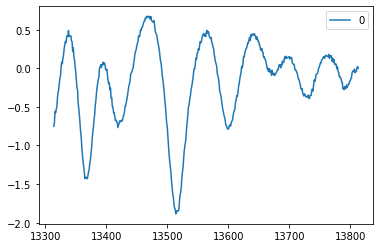

In [96]:
los_outdoor[-500:].plot()

In [ ]:
class DataLoader:
  def __init__(self, path="data/", split='train'):
    self.path = path
    self.split = split
    ts_raw = pd.read_csv(os.path.join(path,f'Electricity-{split}.csv')).iloc[:,1:].values.astype(np.float32)
    self.ts_raw = []
    
    for ts in ts_raw:
      self.ts_raw.append(ts[~np.isnan(ts)])
